In [1]:
%matplotlib inline

# Define dataset and Initital Scaling

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pylab as pl
from IPython import display


In [3]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))

def scale(X, torch=False):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    if torch:
        raise Exception("Not implement yet")
    else:
        X_min = X.min()
        X_max = X.max()
        
    return (X - X_min)/(X_max - X_min), X_min, X_max   

In [4]:
def scale_prior(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)   

In [5]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

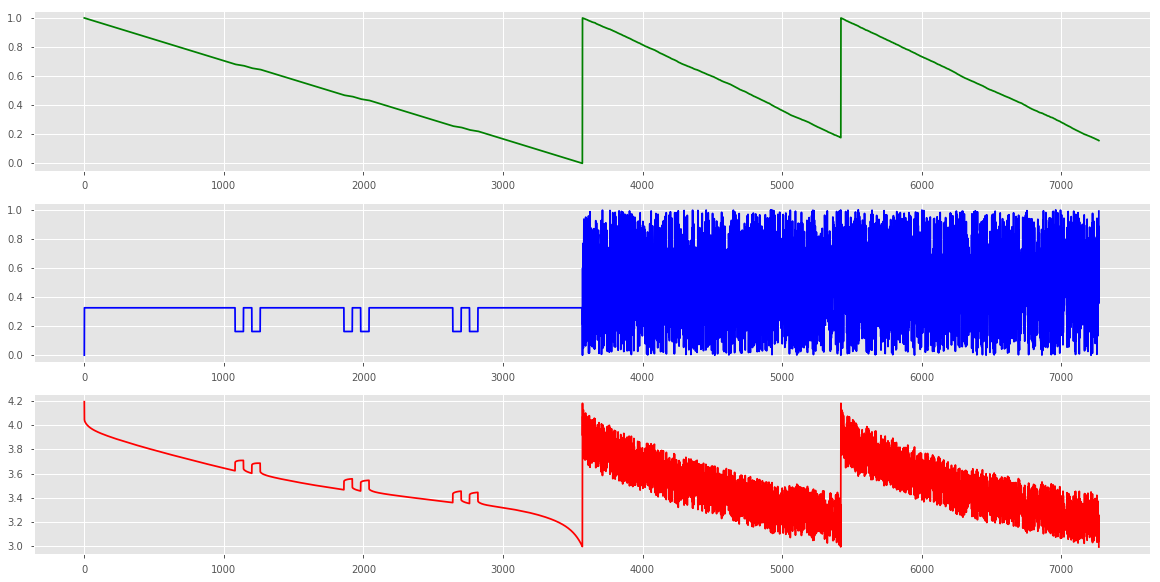

In [6]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC, '-g')
plt.subplot(312)
plt.plot(Current, '-b')
plt.subplot(313)
plt.plot(Voltage, '-r')
plt.show()

## 2. Create a Prior for the network

In [7]:
prior_set = Characterisation_Set['Sets'][0]
SoC_prior_out = scale_prior(prior_set['SoC'].T, SoC_min, SoC_max)
Current_prior = scale_prior(prior_set['Current'].T, Current_min, Current_max)
Voltage_prior = prior_set['Voltage'].T

In [8]:
SoC_prior_in = np.concatenate(([[1.0]], SoC_prior_out[0:-1]))

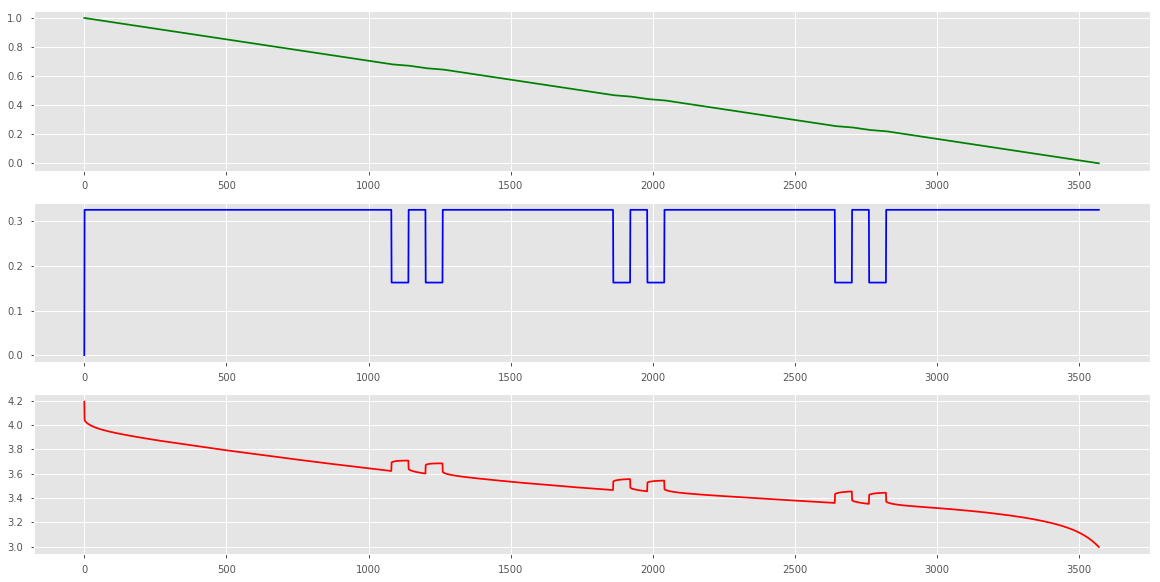

In [9]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC_prior_out, '-g')
plt.subplot(312)
plt.plot(Current_prior, '-b')
plt.subplot(313)
plt.plot(Voltage_prior, '-r')
plt.show()

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class VoCNetwork(nn.Module):
    def __init__(self):
        super(VoCNetwork, self).__init__()
        self.voc_hl1 = nn.Linear(1, 256)
        self.voc_hl2 = nn.Linear(256,256)
        self.voc_hl3 = nn.Linear(256,256)
        self.voc_out = nn.Linear(256, 1)
    def forward(self, SoC):
        voc = torch.sigmoid(self.voc_hl1(SoC))
        voc = torch.sigmoid(self.voc_hl2(voc))
        voc = torch.sigmoid(self.voc_hl3(voc))
        voc = self.voc_out(voc)
        return voc

voc = VoCNetwork()
voc.to(device)
voc_network = "./Trained_Models/VoC_network.mdl"
voc.load_state_dict(torch.load(voc_network))

In [11]:
class Pretrain_Network(nn.Module):
    def __init__(self):
        super(Pretrain_Network, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
    
    def VoC(self, SoC):
        return voc(SoC)
                
    def forward(self, soc, current):
        voltage = torch.empty(current.shape, dtype=torch.float)
        soc_hist = torch.empty(current.shape, dtype=torch.float)
        for t in range(current.shape[1]):
            I = torch.Tensor([[current[t, 0]]])
            I = I.to(device, torch.float)
            soc_in = torch.Tensor([[soc[t, 0]]])
            soc_in = soc_in.to(device, torch.float)
            # Estimate VoC
            VoC = self.VoC(soc_in)

            # Estimate Z_p
            combined = torch.cat((soc_in, I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate V
            scaled_I = I*(Current_max - Current_min) + Current_min
            V = VoC - scaled_I*Z
            voltage[0, t] = V

            # Predict SoC
            soc = soc_in - scaled_I*V/Characterisation_Set['E_crit']
            soc_hist[0, t] = soc
        
        return voltage, soc_hist
    

In [12]:
load_prior_network = None
save_network = "./Battery_Data/new_battery_cycles/Battery_RNN_prior_v3.mdl"

In [13]:
prior = Pretrain_Network()
prior.to(device)

if load_prior_network:
    prior.load_state_dict(torch.load(load_prior_network))
    with torch.no_grad():
        V_est, SoC_est = prior(SoC_prior_in, Current_prior)
        V_est = V_est.to("cpu")
        SoC_est = SoC_est.to("cpu")
    plt.plot(SoC_est.numpy(), V_est.numpy(), '-r')
    plt.plot(SoC_prior_out, Voltage_prior, '-b')
    plt.gca().invert_xaxis()
else:
    # init
    for W in prior.parameters():
        nn.init.normal_(W)
    

# Loss and optimizer
criterion = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(prior.parameters()) 

In [14]:
print(Voltage_prior.shape)
print(SoC_prior_in.shape)
print(Current_prior.shape)

(3570, 1)
(3570, 1)
(3570, 1)


In [15]:
import time
import math

epochs = 10000
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
prior.train()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

for epoch in range(epochs):
    count = -1
    avg_loss = 0
    
    V = torch.from_numpy(Voltage_prior).float()
    optimizer.zero_grad()
    V_est, SoC_est = prior(SoC_prior_in, Current_prior)
    loss = criterion(V_est, V)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
    loss_hist.append(loss.item())
    if epoch % 5 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        print("New average minimum: ", avg_loss)
        torch.save(prior.state_dict(), save_network)
        loss_min = avg_loss

epoch 0, time since start: 0m 0s, estimated remaining time: 0h 1m 51s
epoch 5, time since start: 0m 0s, estimated remaining time: 0h 0m 37s
epoch 10, time since start: 0m 0s, estimated remaining time: 0h 0m 29s
New average minimum:  0.031859565526247025
epoch 15, time since start: 0m 0s, estimated remaining time: 0h 0m 28s
epoch 20, time since start: 0m 0s, estimated remaining time: 0h 0m 27s
epoch 25, time since start: 0m 0s, estimated remaining time: 0h 0m 26s
epoch 30, time since start: 0m 0s, estimated remaining time: 0h 0m 25s
epoch 35, time since start: 0m 0s, estimated remaining time: 0h 0m 25s
New average minimum:  1.4045207219481881e-09
epoch 40, time since start: 0m 0s, estimated remaining time: 0h 0m 25s
epoch 45, time since start: 0m 0s, estimated remaining time: 0h 0m 25s
epoch 50, time since start: 0m 0s, estimated remaining time: 0h 0m 24s
epoch 55, time since start: 0m 0s, estimated remaining time: 0h 0m 24s
epoch 60, time since start: 0m 0s, estimated remaining time: 0

epoch 585, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 590, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 595, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 600, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 605, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 610, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 615, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 620, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 625, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 630, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 635, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 640, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 645, time since start: 0m 1s, estimated remaining time: 0h 0m 19s
epoch 650, time since start: 0m 1s, estimated remaining time: 0h

epoch 1205, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1210, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1215, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1220, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1225, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1230, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1235, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1240, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1245, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1250, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1255, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1260, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1265, time since start: 0m 2s, estimated remaining time: 0h 0m 17s
epoch 1270, time since start: 0m 2s, estimated rema

epoch 1820, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1825, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1830, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1835, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1840, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1845, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1850, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1855, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1860, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1865, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1870, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1875, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1880, time since start: 0m 3s, estimated remaining time: 0h 0m 16s
epoch 1885, time since start: 0m 3s, estimated rema

epoch 2450, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2455, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2460, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2465, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2470, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2475, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2480, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2485, time since start: 0m 4s, estimated remaining time: 0h 0m 15s
epoch 2490, time since start: 0m 5s, estimated remaining time: 0h 0m 15s
epoch 2495, time since start: 0m 5s, estimated remaining time: 0h 0m 15s
epoch 2500, time since start: 0m 5s, estimated remaining time: 0h 0m 15s
epoch 2505, time since start: 0m 5s, estimated remaining time: 0h 0m 15s
epoch 2510, time since start: 0m 5s, estimated remaining time: 0h 0m 15s
epoch 2515, time since start: 0m 5s, estimated rema

epoch 3060, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3065, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3070, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3075, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3080, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3085, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3090, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3095, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3100, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3105, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3110, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3115, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3120, time since start: 0m 6s, estimated remaining time: 0h 0m 13s
epoch 3125, time since start: 0m 6s, estimated rema

epoch 3695, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3700, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3705, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3710, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3715, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3720, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3725, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3730, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3735, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3740, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3745, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3750, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3755, time since start: 0m 7s, estimated remaining time: 0h 0m 12s
epoch 3760, time since start: 0m 7s, estimated rema

epoch 4335, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4340, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4345, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4350, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4355, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4360, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4365, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4370, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4375, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4380, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4385, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4390, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4395, time since start: 0m 8s, estimated remaining time: 0h 0m 11s
epoch 4400, time since start: 0m 8s, estimated rema

epoch 4975, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 4980, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 4985, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 4990, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 4995, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5000, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5005, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5010, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5015, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5020, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5025, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5030, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5035, time since start: 0m 9s, estimated remaining time: 0h 0m 9s
epoch 5040, time since start: 0m 9s, estimated remaining time: 0

epoch 5565, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5570, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5575, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5580, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5585, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5590, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5595, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5600, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5605, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5610, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5615, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5620, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
New average minimum:  4.405381007904774e-12
epoch 5625, time since start: 0m 11s, estimated remaining time: 0h 0m 8s
epoch 5

epoch 6200, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6205, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6210, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6215, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6220, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6225, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6230, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6235, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6240, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6245, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6250, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6255, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6260, time since start: 0m 12s, estimated remaining time: 0h 0m 7s
epoch 6265, time since start: 0m 12s, estimated rem

epoch 6815, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6820, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6825, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6830, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6835, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6840, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6845, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6850, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6855, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6860, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6865, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6870, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6875, time since start: 0m 13s, estimated remaining time: 0h 0m 6s
epoch 6880, time since start: 0m 13s, estimated rem

epoch 7445, time since start: 0m 14s, estimated remaining time: 0h 0m 5s
epoch 7450, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7455, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7460, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7465, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7470, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7475, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7480, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7485, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7490, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7495, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7500, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7505, time since start: 0m 15s, estimated remaining time: 0h 0m 5s
epoch 7510, time since start: 0m 15s, estimated rem

epoch 8065, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8070, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8075, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8080, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8085, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8090, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8095, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8100, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8105, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8110, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8115, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8120, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8125, time since start: 0m 16s, estimated remaining time: 0h 0m 3s
epoch 8130, time since start: 0m 16s, estimated rem

epoch 8645, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8650, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8655, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8660, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8665, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8670, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8675, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8680, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8685, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8690, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8695, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8700, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8705, time since start: 0m 17s, estimated remaining time: 0h 0m 2s
epoch 8710, time since start: 0m 17s, estimated rem

epoch 9275, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9280, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9285, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9290, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9295, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9300, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9305, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9310, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9315, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9320, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9325, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9330, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9335, time since start: 0m 18s, estimated remaining time: 0h 0m 1s
epoch 9340, time since start: 0m 18s, estimated rem

epoch 9920, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9925, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9930, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9935, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9940, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9945, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9950, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9955, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9960, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9965, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9970, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9975, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9980, time since start: 0m 20s, estimated remaining time: 0h 0m 0s
epoch 9985, time since start: 0m 20s, estimated rem

(3570, 1) (3570, 1)


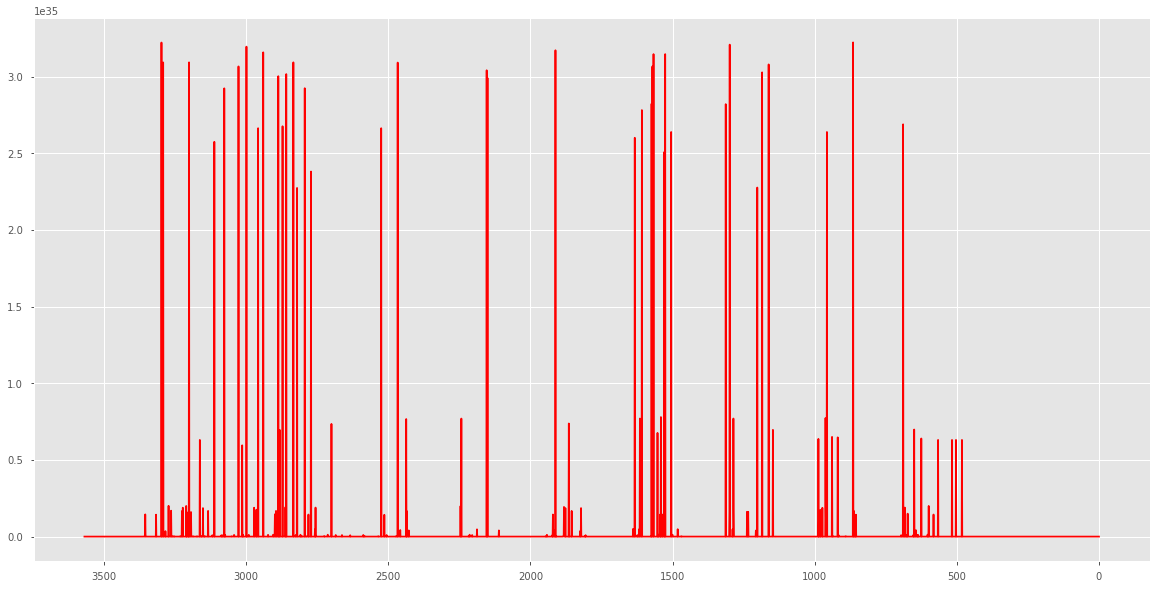

In [21]:
with torch.no_grad():
    V_est, SoC_est = prior(SoC_prior_in, Current_prior)
    V_est = V_est.to("cpu").numpy()
    SoC_est = SoC_est.to("cpu").numpy()
print(V_est.shape, SoC_est.shape)
plt.plot(V_est, '-r')
# plt.plot(SoC_prior_out, Voltage_prior, '-b')
plt.gca().invert_xaxis()